In [147]:
import keras
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam

np.random.seed(1)

# Open the AAPL stock file from the ticker_data dir
TICKER_DIR = "C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\data\\tickers\\ticker_data"
df = pd.read_csv(f"{TICKER_DIR}\\AXP.csv", header=0)

print(df.shape)

# Our target is the close price of the stock
target = df["close"].tail(1000)
dataset = df[["high", "low", "open"]].tail(1000)

(1006, 13)


In [148]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i, _ in enumerate(sequences):
		end_ix = i + n_steps
		if end_ix > len(sequences):
			break
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix-1, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

n_steps = 3

high = dataset["high"].values.reshape(len(dataset), 1)
low = dataset["low"].values.reshape(len(dataset), 1)
open = dataset["open"].values.reshape(len(dataset), 1)
close = target.values.reshape(len(dataset), 1)

# stack them horizontally
d = np.hstack((open, high, low, close))
# split sequences
sc = MinMaxScaler()
d_sc = sc.fit_transform(d)
X, y = split_sequences(d_sc, n_steps)

n_features = X.shape[2]
print(d.shape)
print(X.shape)
print(y.shape)



(1000, 4)
(998, 3, 4)
(998, 4)


In [154]:
# clears previous sessions
keras.backend.clear_session()
# create a Sequential model, 2 LSTM 100 node layers & 1 fully connected layer
model = Sequential()
model.add(LSTM(100, activation="relu", return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation="relu"))
model.add(Dense(n_features))
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="mae", metrics=["mae", "mse"])

# split dataset to training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

model.fit(X_train, y_train, epochs=250, verbose=2)

Epoch 1/250
 - 1s - loss: 0.3573 - mae: 0.3573 - mse: 0.1917
Epoch 2/250
 - 0s - loss: 0.1003 - mae: 0.1003 - mse: 0.0213
Epoch 3/250
 - 0s - loss: 0.0381 - mae: 0.0381 - mse: 0.0024
Epoch 4/250
 - 0s - loss: 0.0286 - mae: 0.0286 - mse: 0.0015
Epoch 5/250
 - 0s - loss: 0.0182 - mae: 0.0182 - mse: 7.3551e-04
Epoch 6/250
 - 0s - loss: 0.0133 - mae: 0.0133 - mse: 4.0760e-04
Epoch 7/250
 - 0s - loss: 0.0112 - mae: 0.0112 - mse: 2.9406e-04
Epoch 8/250
 - 0s - loss: 0.0116 - mae: 0.0116 - mse: 2.9938e-04
Epoch 9/250
 - 0s - loss: 0.0102 - mae: 0.0102 - mse: 2.5154e-04
Epoch 10/250
 - 0s - loss: 0.0139 - mae: 0.0139 - mse: 3.7561e-04
Epoch 11/250
 - 0s - loss: 0.0109 - mae: 0.0109 - mse: 2.6609e-04
Epoch 12/250
 - 0s - loss: 0.0099 - mae: 0.0099 - mse: 2.3511e-04
Epoch 13/250
 - 0s - loss: 0.0097 - mae: 0.0097 - mse: 2.3053e-04
Epoch 14/250
 - 0s - loss: 0.0101 - mae: 0.0101 - mse: 2.3463e-04
Epoch 15/250
 - 0s - loss: 0.0094 - mae: 0.0094 - mse: 2.1571e-04
Epoch 16/250
 - 0s - loss: 0.0096 -

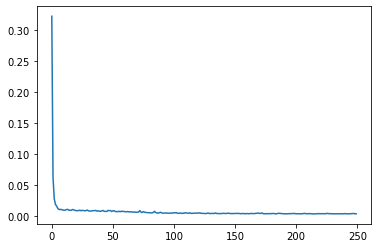

In [150]:
# plot the model's loss history
model.history.history.keys()
plt.plot(model.history.history["loss"])

In [151]:
# evaluate the model with the testing datasets
scores = model.evaluate(X_test, y_test, verbose=0)
print(*[f"History Item [{item}] reports value of {value}" for value, item in zip(scores, model.metrics_names)], sep="\n")

History Item [loss] reports value of 0.004389232248067856
History Item [mae] reports value of 0.004389232490211725
History Item [mse] reports value of 3.277722862549126e-05


In [152]:
# take the last 36 close values for testing
# 36 is the size of the testing set
# actual = df["close"].tail(X_test.shape[0]).values
# sc.data_range_

actual = y_test[:, -1]
yhat = model.predict(X_test, verbose=0)
yhat.shape
predictions = yhat[:, -1]

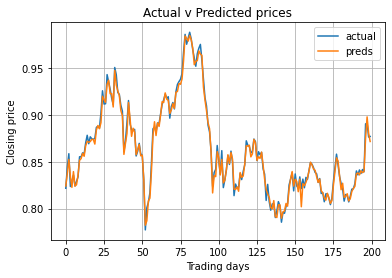

In [153]:
# plot the predicted values against the actual values
fig = plt.figure()
plt.title("Actual v Predicted prices")
plt.ylabel("Closing price")
plt.xlabel("Trading days")
plt.plot(actual, label="actual")
plt.plot(predictions, label="preds")
plt.grid()
plt.legend()
# plt.savefig("C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\data\\tickers\\MSFT.png")